In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.diagnostic import plot_covariance_contour, plot_covariance_corner
from lisatools.sensitivity import get_sensitivity, A1TDISens
from lisatools.detector import scirdv1, Orbits, DefaultOrbits, LISAModel
from lisatools.utils.constants import *
from lisatools.sources import BBHCalculationController, GBCalculationController, EMRICalculationController
from lisatools.sources.emri import EMRITDIWaveform
from lisatools.sources.bbh import BBHSNRWaveform
from lisatools.sources.gb import GBAETWaveform
from lisatools.stochastic import StochasticContribution, StochasticContributionContainer

from gwspaceperf import Mission
from gwspaceperf.performance import compute_noise_cov

import os
from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_46901/1076478813.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


Define model class based on `lisatools.detector.LISAModel`. This interacts with the sensitivity curve generator inside `lisatools` to properly include model information.

In [2]:
class Space2050Model:
    """Model for future space-based GW missions.

    Args:
        mission: ``gwspaceperf.Mission``.
        orbits: ``lisatools.detector.Orbits``.
        name: Name for model instance.

    """

    def __init__(self, mission: Mission, orbits: Orbits, name: str):
        # store spline
        self.orbits = orbits
        self.name = name
        self._setup_splines(mission)

    @property
    def Sn_spl(self) -> interpolate.CubicSpline | None:
        """PSD spline dictionary."""
        if not hasattr(self, "_Sn_spl"):
            return None

        return self._Sn_spl

    @property
    def fn(self) -> np.ndarray:
        """Frequency array for splines."""
        return self._fn

    def _setup_splines(self, mission: Mission) -> None:
        """Prepare the splines accordingly"""
        Sn = compute_noise_cov(mission, "AET")
        self._fn = mission.f
        self._Sn_spl = {
            key: interpolate.CubicSpline(self._fn, Sn[0, :, i, i])
            for i, key in enumerate(["A", "E", "T"])
        }

## Define Stochastic Contributions

In [3]:
from dataclasses import dataclass

@dataclass
class GWBModel:
    name: str
    fn: np.ndarray  # frequencies
    Sh: np.ndarray  # FFD PSD (1/HZ)

class Space2050GWB(StochasticContribution):
    outside_return_val = np.inf
    @classmethod
    def specific_Sh_function(
        cls, f: float | np.ndarray, stoch_model: GWBModel
    ) -> float | np.ndarray:
        """Calculate the power spectral density contained in a stochastic signal contribution.

        ## PERFORMS LINEAR INTERPOLATION with Numpy

        Args:
            f: Frequency array.
            *args: Any arguments for the function.
            **kwargs: Any keyword arguments for the function.

        Returns:
            Power spectral density contained in stochastic signal.

        """

        return np.interp(f, stoch_model.fn, stoch_model.Sh, left=cls.outside_return_val, right=cls.outside_return_val)


GWB_DO_con_HS
GWB_LISA_LS
GWB_LISA_max_HS
GWB_DO_con_LS
GWB_LISA_max_LS
GWB_LISA_HS


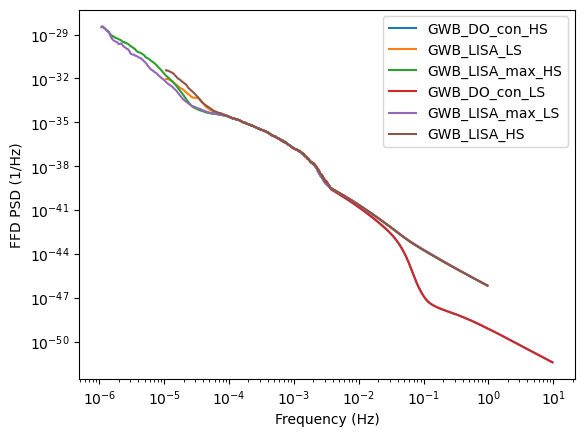

In [4]:

stochastic_contributions = {}
path_to_models_folder = "../space_2050_models/"
for fp in os.listdir(path_to_models_folder):
    if fp[:3] == "GWB":
        name = fp.split(".dat")[0]
        f, hn = np.genfromtxt(path_to_models_folder + fp).T

        Sn = hn ** 2 / f
        plt.loglog(f, Sn, label=name)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("FFD PSD (1/Hz)")
        print(name)

        stochastic_contributions[name] = GWBModel(name, f, Sn)
        
plt.legend()

## Define mission characteristics

In [5]:
# Define a frequency axis
f_mu = np.logspace(-7, 0, 1000)
f_m = np.logspace(-4, 0, 1000)
f_d = np.logspace(-3, 1, 1000)

# Define the LISA-like mission
lisa_mission = Mission.LISA(f_m)
lisamax_mission = Mission.LISAmax(f_mu)
do_con_mission = Mission.DO_conservative(f_d)
do_opt_mission = Mission.DO_optimal(f_d)
# amigo = Mission.AMIGO(f_m)
muares_mission = Mission.muAres(f_mu)

In [6]:
missions = {}

def get_df(Tobs: float, dt: float) -> float:
    Nobs = int(Tobs / dt)
    Tobs = Nobs * dt
    df = 1 / Tobs
    return df


In [7]:
lisa_orbits = Orbits("../space_2050_models/lisa_orbits.h5", armlength=2.5e9)

lisa = Space2050Model(
    lisa_mission, lisa_orbits, "lisa"
)

for stoch in ["GWB_LISA_HS", "GWB_LISA_LS"]:
    psd_kwargs = dict(
        stochastic_function=Space2050GWB,
        stochastic_params=(stochastic_contributions[stoch],),
    )
    missions["lisa_" + stoch] = dict(
        model=lisa,
        psd_kwargs=psd_kwargs,
        Tobs=YRSID_SI, 
        dt=10.0
    )

In [8]:



lisamax_orbits = Orbits("../space_2050_models/lisamax_orbits.h5", armlength=2.59e+11)
lisa_max = Space2050Model(
    lisamax_mission, lisamax_orbits, "lisa_max"
)

for stoch in ["GWB_LISA_max_HS", "GWB_LISA_max_LS"]:
    psd_kwargs = dict(
        stochastic_function=Space2050GWB,
        stochastic_params=(stochastic_contributions[stoch],),
    )
    missions["lisamax_" + stoch] = dict(
        model=lisa_max,
        psd_kwargs=psd_kwargs,
        Tobs=YRSID_SI, 
        dt=20.0
    )



muares = Space2050Model(
    muares_mission, lisamax_orbits, "muares"
)

# ASSUMES GWB for LISA Max for muares
for stoch in ["GWB_LISA_max_HS", "GWB_LISA_max_LS"]:
    psd_kwargs = dict(
        stochastic_function=Space2050GWB,
        stochastic_params=(stochastic_contributions[stoch],),
    )
    missions["muares_" + stoch] = dict(
        model=muares,
        psd_kwargs=psd_kwargs,
        Tobs=YRSID_SI, 
        dt=20.0
    )



In [9]:
do_orbits = Orbits("../space_2050_models/deci_orbits.h5", armlength=1e8)

do_con = Space2050Model(
    do_con_mission, do_orbits, "do_con"
)

# ASSUMES GWB for LISA Max for muares
for stoch in ["GWB_DO_con_HS", "GWB_DO_con_LS"]:
    psd_kwargs = dict(
        stochastic_function=Space2050GWB,
        stochastic_params=(stochastic_contributions[stoch],),
    )
    missions["do_con_" + stoch] = dict(
        model=do_con,
        psd_kwargs=psd_kwargs,
        Tobs=YRSID_SI / 2.0, 
        dt=0.5
    )


do_opt = Space2050Model(
    do_opt_mission, do_orbits, "do_opt"
)

# ASSUMES GWB for LISA Max for muares
for stoch in ["GWB_DO_con_HS", "GWB_DO_con_LS"]:
    psd_kwargs = dict(
        stochastic_function=Space2050GWB,
        stochastic_params=(stochastic_contributions[stoch],),
    )

    # ASSUMES GW_DO_CONS_HS 
    missions["do_opt_" + stoch] = dict(
        model=do_opt,
        psd_kwargs=psd_kwargs,
        Tobs=YRSID_SI / 2.0, 
        dt=0.5
    )





### DO conservative comparison with and without stochastic contribution

/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


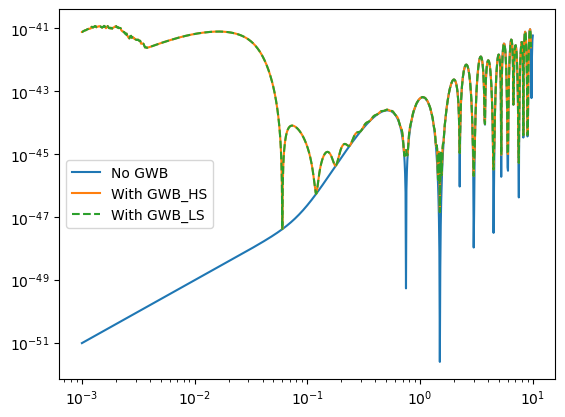

In [10]:
fn = missions["do_con_GWB_DO_con_HS"]["model"].fn
Sn_no_GWB = get_sensitivity(fn, model=missions["do_con_GWB_DO_con_HS"]["model"], sens_fn=A1TDISens)
plt.loglog(fn, Sn_no_GWB, c=f"C0", label="No GWB")
Sn_with_GWB_HS = get_sensitivity(fn, model=missions["do_con_GWB_DO_con_HS"]["model"], sens_fn=A1TDISens, **missions["do_con_GWB_DO_con_HS"]["psd_kwargs"])
plt.loglog(fn, Sn_with_GWB_HS, c=f"C1", label="With GWB_HS")
fn = missions["do_con_GWB_DO_con_LS"]["model"].fn
Sn_with_GWB_LS = get_sensitivity(fn, model=missions["do_con_GWB_DO_con_LS"]["model"], sens_fn=A1TDISens, **missions["do_con_GWB_DO_con_LS"]["psd_kwargs"])
plt.loglog(fn, Sn_with_GWB_LS, c=f"C2", ls="--", label="With GWB_LS")
plt.legend()


### LISA comparison with and without stochastic contribution

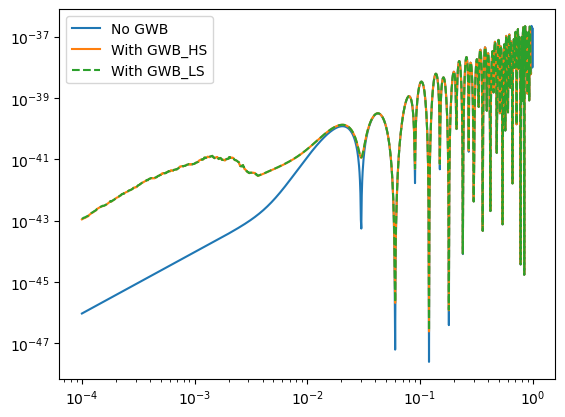

In [11]:
fn = missions["lisa_GWB_LISA_HS"]["model"].fn
Sn_no_GWB = get_sensitivity(fn, model=missions["lisa_GWB_LISA_HS"]["model"], sens_fn=A1TDISens)
plt.loglog(fn, Sn_no_GWB, c=f"C0", label="No GWB")
Sn_with_GWB_HS = get_sensitivity(fn, model=missions["lisa_GWB_LISA_HS"]["model"], sens_fn=A1TDISens, **missions["lisa_GWB_LISA_HS"]["psd_kwargs"])
plt.loglog(fn, Sn_with_GWB_HS, c=f"C1", label="With GWB_HS")
fn = missions["lisa_GWB_LISA_LS"]["model"].fn
Sn_with_GWB_LS = get_sensitivity(fn, model=missions["lisa_GWB_LISA_LS"]["model"], sens_fn=A1TDISens, **missions["lisa_GWB_LISA_LS"]["psd_kwargs"])
plt.loglog(fn, Sn_with_GWB_LS, c=f"C2", ls="--", label="With GWB_LS")
plt.legend()

### LISA Max comparison with and without stochastic contribution

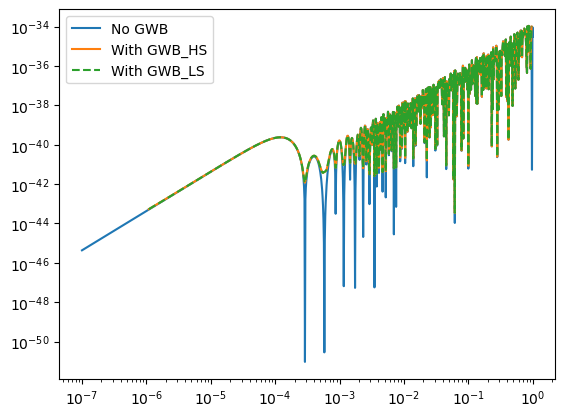

In [12]:
fn = missions["lisamax_GWB_LISA_max_HS"]["model"].fn
Sn_no_GWB = get_sensitivity(fn, model=missions["lisamax_GWB_LISA_max_HS"]["model"], sens_fn=A1TDISens)
plt.loglog(fn, Sn_no_GWB, c=f"C0", label="No GWB")
Sn_with_GWB_HS = get_sensitivity(fn, model=missions["lisamax_GWB_LISA_max_HS"]["model"], sens_fn=A1TDISens, **missions["lisamax_GWB_LISA_max_HS"]["psd_kwargs"])
plt.loglog(fn, Sn_with_GWB_HS, c=f"C1", label="With GWB_HS")
fn = missions["lisamax_GWB_LISA_max_LS"]["model"].fn
Sn_with_GWB_LS = get_sensitivity(fn, model=missions["lisamax_GWB_LISA_max_LS"]["model"], sens_fn=A1TDISens, **missions["lisamax_GWB_LISA_max_LS"]["psd_kwargs"])
plt.loglog(fn, Sn_with_GWB_LS, c=f"C2", ls="--", label="With GWB_LS")
plt.legend()

## Diagnostics

Setup all snr calculators

In [13]:
for mission in missions:
    print(mission)
    orbits_here = missions[mission]["model"].orbits
    # black hole generator
    bbh = BBHSNRWaveform(response_kwargs=dict(TDItag="AET", orbits=orbits_here, tdi2=True))

    missions[mission]["bbh"] = BBHCalculationController(
        bbh, 
        missions[mission]["model"],
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,
        missions[mission]["dt"],
        psd=A1TDISens
    )
    
    # gb generator
    gb = GBAETWaveform(orbits=orbits_here)

    missions[mission]["gb"] = GBCalculationController(
        gb, 
        missions[mission]["model"], 
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,
        missions[mission]["dt"],
        psd=A1TDISens
    )

    # emri generator
    emri = EMRITDIWaveform(
        T=missions[mission]["Tobs"] / YRSID_SI,  # in sec
        dt=missions[mission]["dt"], 
        response_kwargs=dict(tdi="2nd generation", orbits=orbits_here)
    )

    missions[mission]["emri"] = EMRICalculationController(
        emri, missions[mission]["model"], 
        missions[mission]["psd_kwargs"], 
        missions[mission]["Tobs"] / YRSID_SI,  # in sec
        missions[mission]["dt"],
        psd=A1TDISens
    )
    


lisa_GWB_LISA_HS
lisa_GWB_LISA_LS
lisamax_GWB_LISA_max_HS
lisamax_GWB_LISA_max_LS
muares_GWB_LISA_max_HS
muares_GWB_LISA_max_LS
do_con_GWB_DO_con_HS
do_con_GWB_DO_con_LS
do_opt_GWB_DO_con_HS
do_opt_GWB_DO_con_LS


### MBHBs

/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/lisatools/sensitivity.py:642: ComplexWarning: Casting complex values to real discards the imaginary part
  self._sens_mat = np.asarray(list(new_out), dtype=float).reshape(
/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_46901/2858484454.py:29: RuntimeWarning: invalid value encountered in divide
  ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_46901/2858484454.py:29: RuntimeWarning: invalid value encountered in multiply
  ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")


lisa_GWB_LISA_HS 2445.811483235008
lisa_GWB_LISA_LS 2437.691199265753
lisamax_GWB_LISA_max_HS 117519.65472112407
lisamax_GWB_LISA_max_LS 117512.39394184104
muares_GWB_LISA_max_HS 302734.10657607735
muares_GWB_LISA_max_LS 302333.0104718371
do_con_GWB_DO_con_HS 0.611020862118207
do_con_GWB_DO_con_LS 0.6110206118201895
do_opt_GWB_DO_con_HS 0.6110208622105451
do_opt_GWB_DO_con_LS 0.6110206119125275


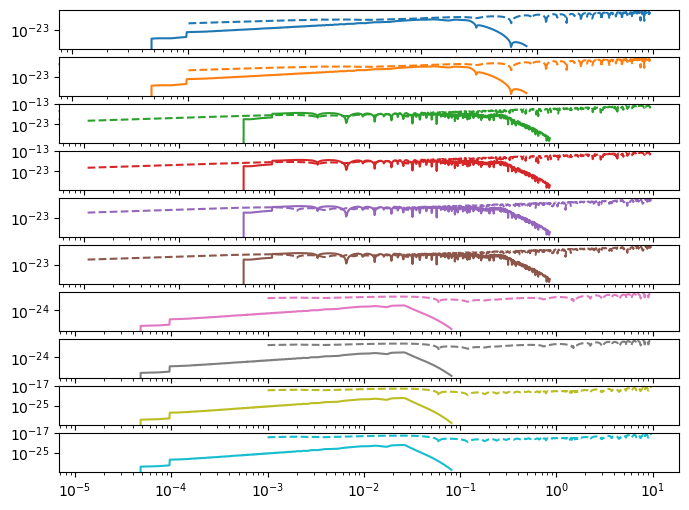

In [14]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["bbh"].get_snr(*mbh_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["bbh"].f_arr, mission["bbh"].f_arr * np.abs(mission["bbh"].last_output[0]), c=f"C{i}")
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")


In [15]:
# example with last mission
scaled_inj_params, cov = mission["bbh"].get_cov(
    *mbh_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-9,
    deriv_inds=None,
)


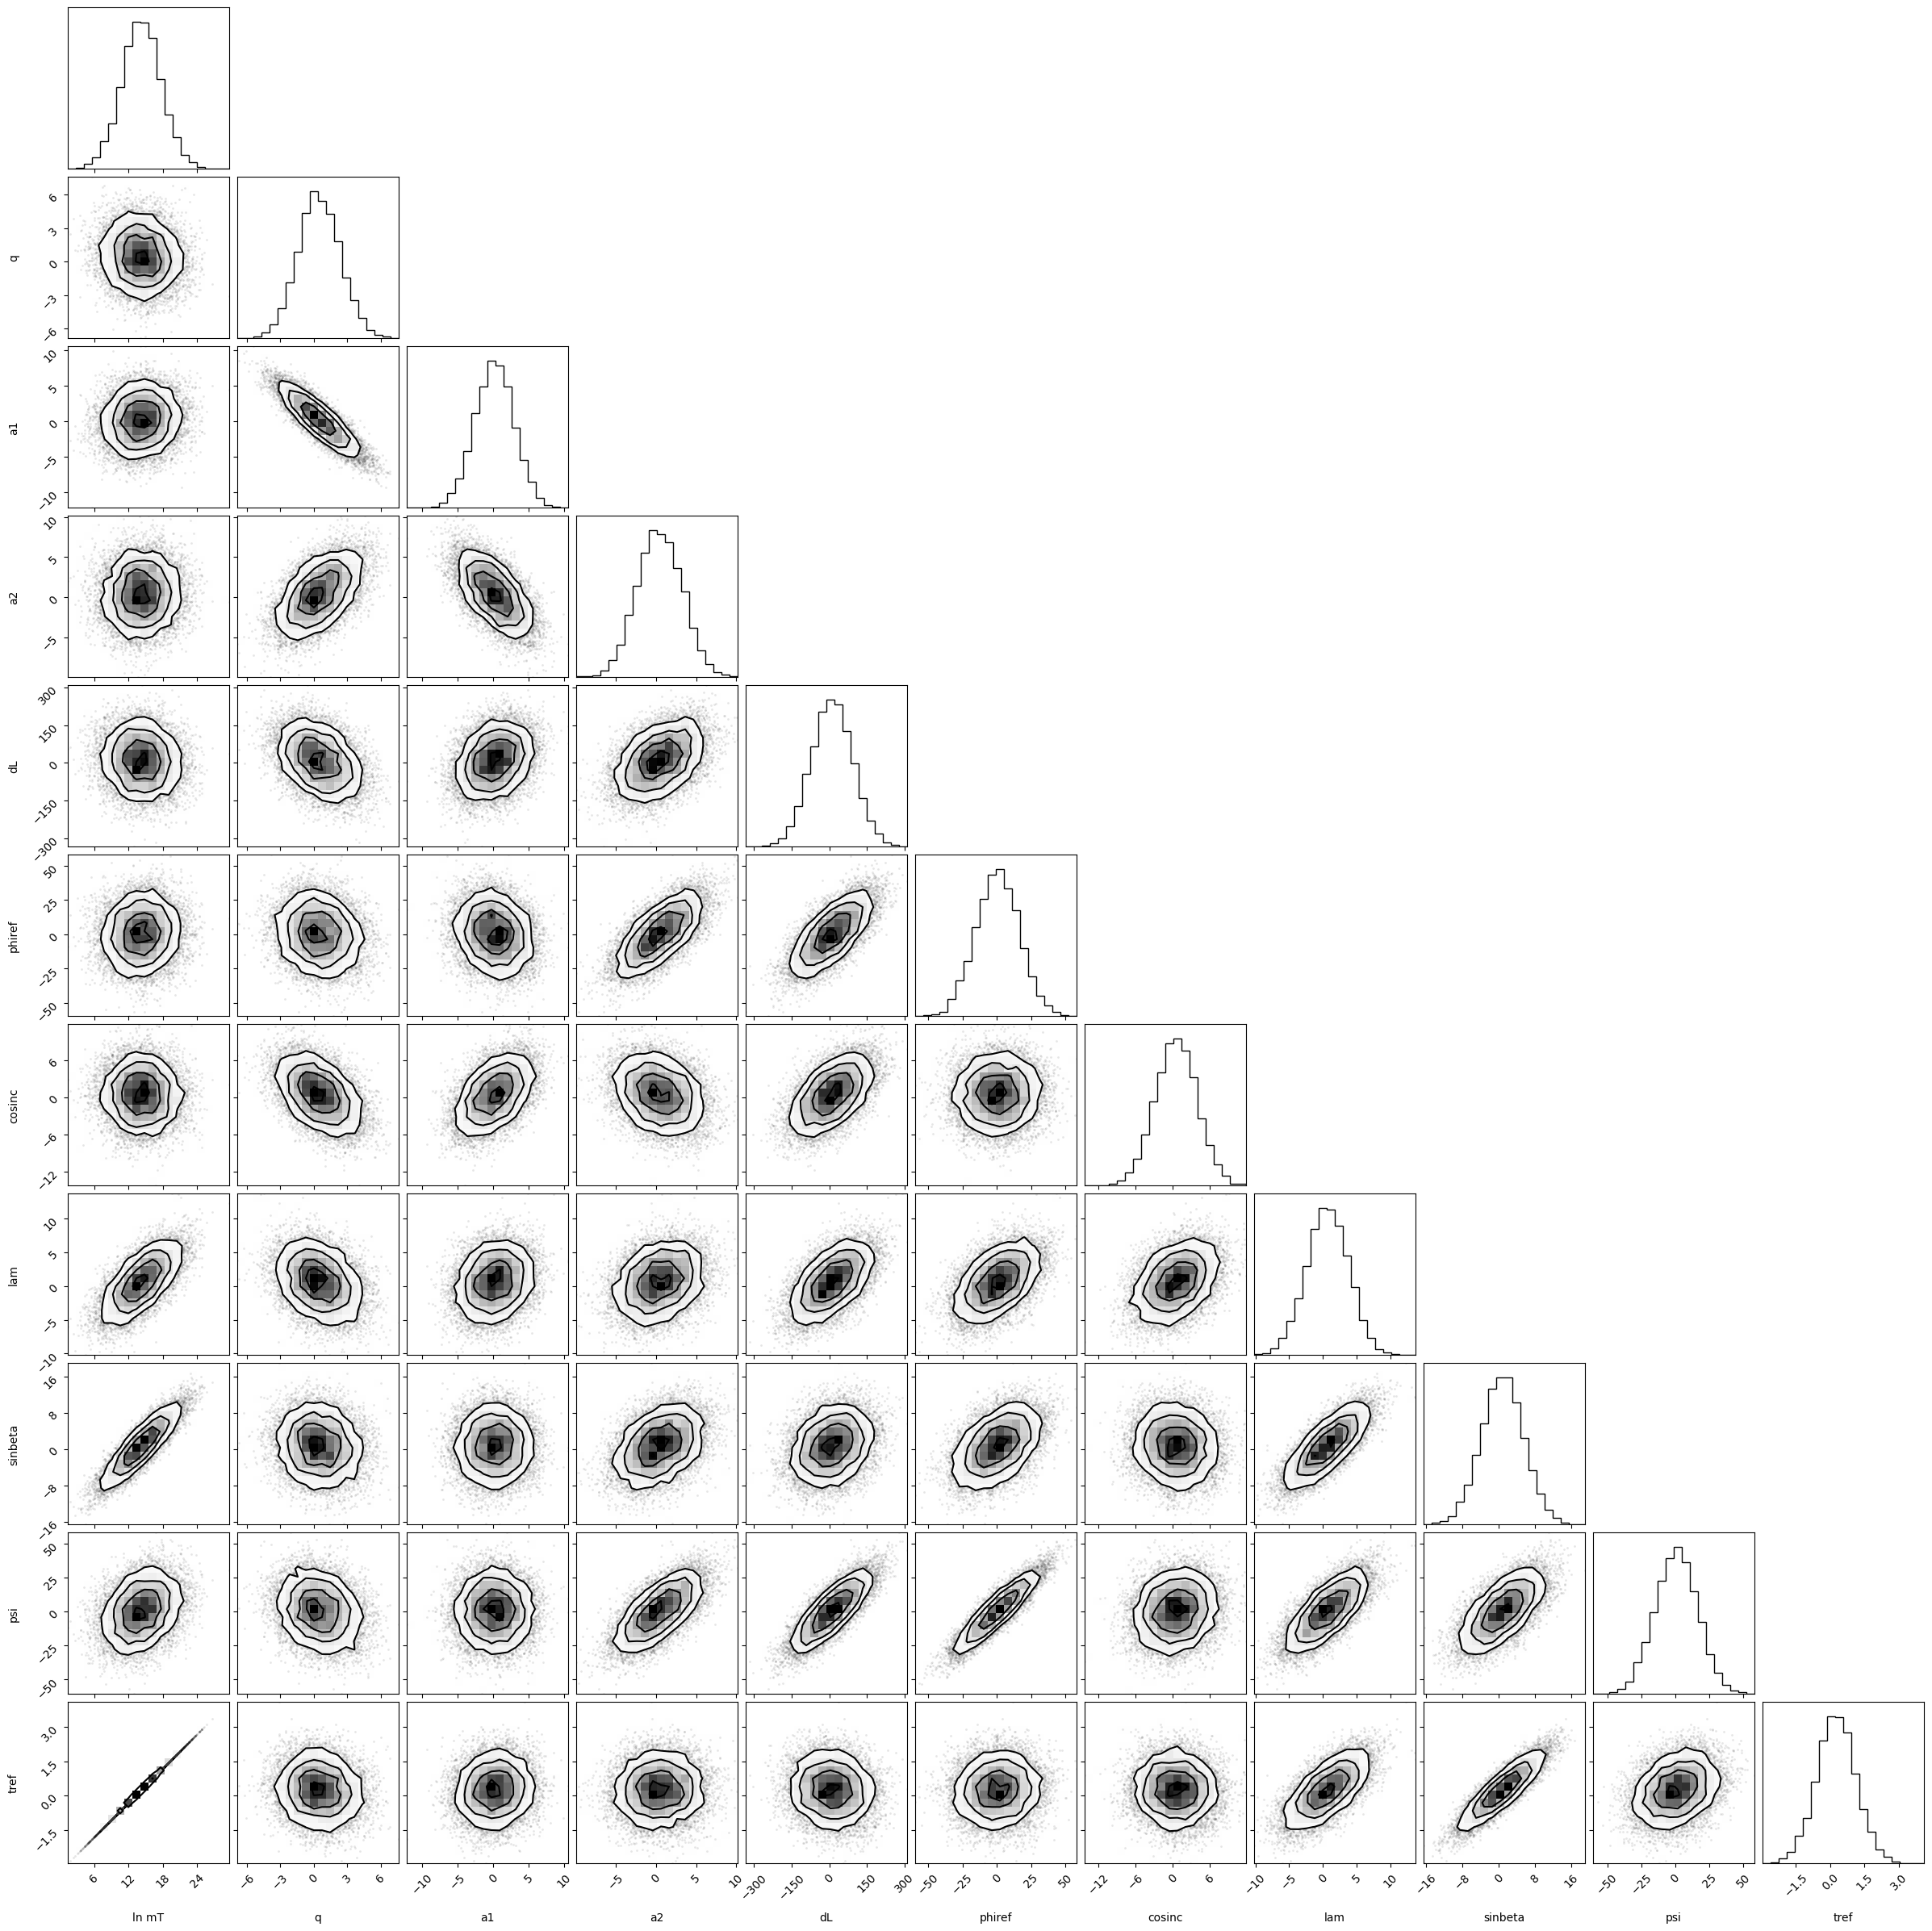

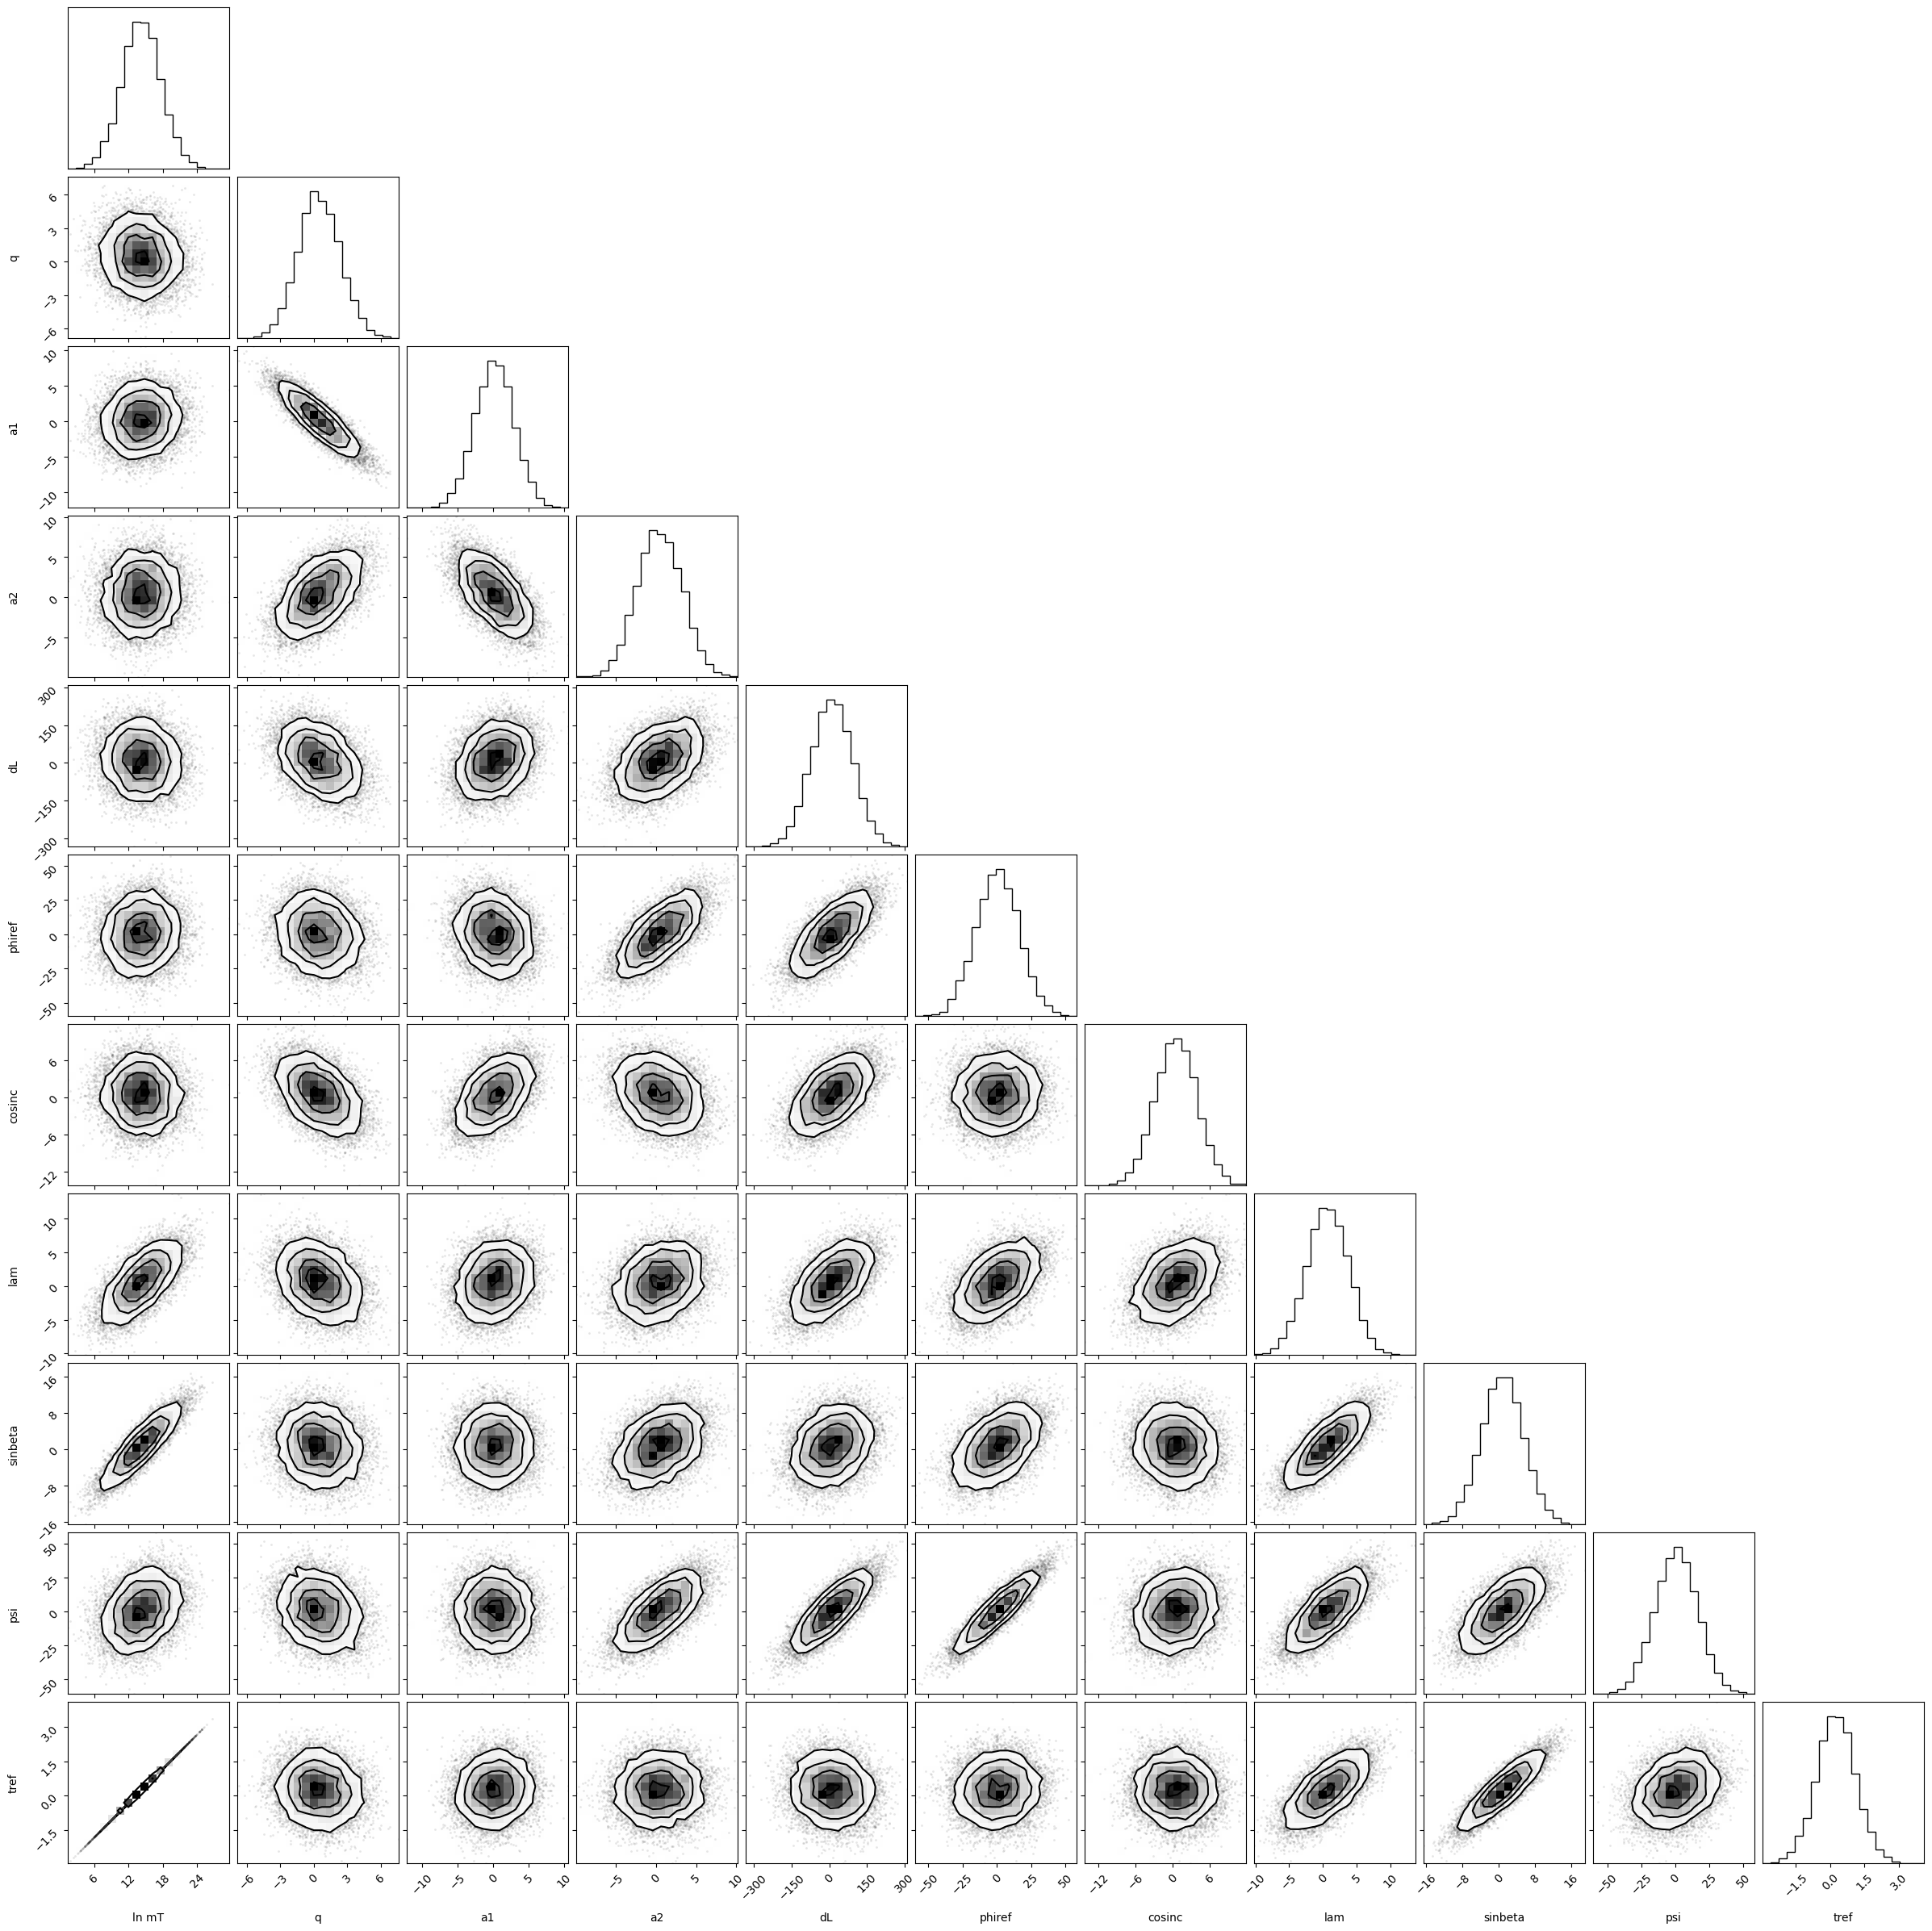

In [16]:
labels=["ln mT", "q", "a1", "a2", "dL", "phiref", "cosinc", "lam", "sinbeta", "psi", "tref"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

### GBs

/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/lisatools/sensitivity.py:642: ComplexWarning: Casting complex values to real discards the imaginary part
  self._sens_mat = np.asarray(list(new_out), dtype=float).reshape(
/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_46901/1873208545.py:19: RuntimeWarning: invalid value encountered in divide
  ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_46901/1873208545.py:19: RuntimeWarning: invalid value encountered in multiply
  ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex valu

lisa_GWB_LISA_HS 83.10350707502931
lisa_GWB_LISA_LS 82.71906182325506
lisamax_GWB_LISA_max_HS 128.2190869503453
lisamax_GWB_LISA_max_LS 128.1827135291382
muares_GWB_LISA_max_HS 309.74416521512126
muares_GWB_LISA_max_LS 309.2312628011145
do_con_GWB_DO_con_HS 0.004435980296156252
do_con_GWB_DO_con_LS 0.004435924686404198
do_opt_GWB_DO_con_HS 0.004435980296156309
do_opt_GWB_DO_con_LS 0.0044359246864042546


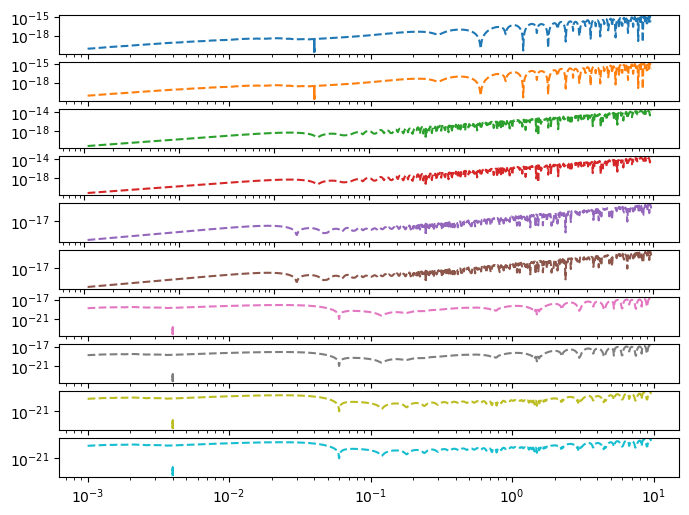

In [17]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    print(name, mission["gb"].get_snr(*gb_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    ax[i].loglog(mission["gb"].f_arr, mission["gb"].f_arr * np.abs(mission["gb"].last_output[0]), c=f"C{i}")
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")

In [18]:
scaled_inj_params, cov = mission["gb"].get_cov(
    *gb_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-11,
    deriv_inds=None,
)

/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/lisatools/diagnostic.py:686: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samp = np.random.multivariate_normal(params, cov, size=nsamp)


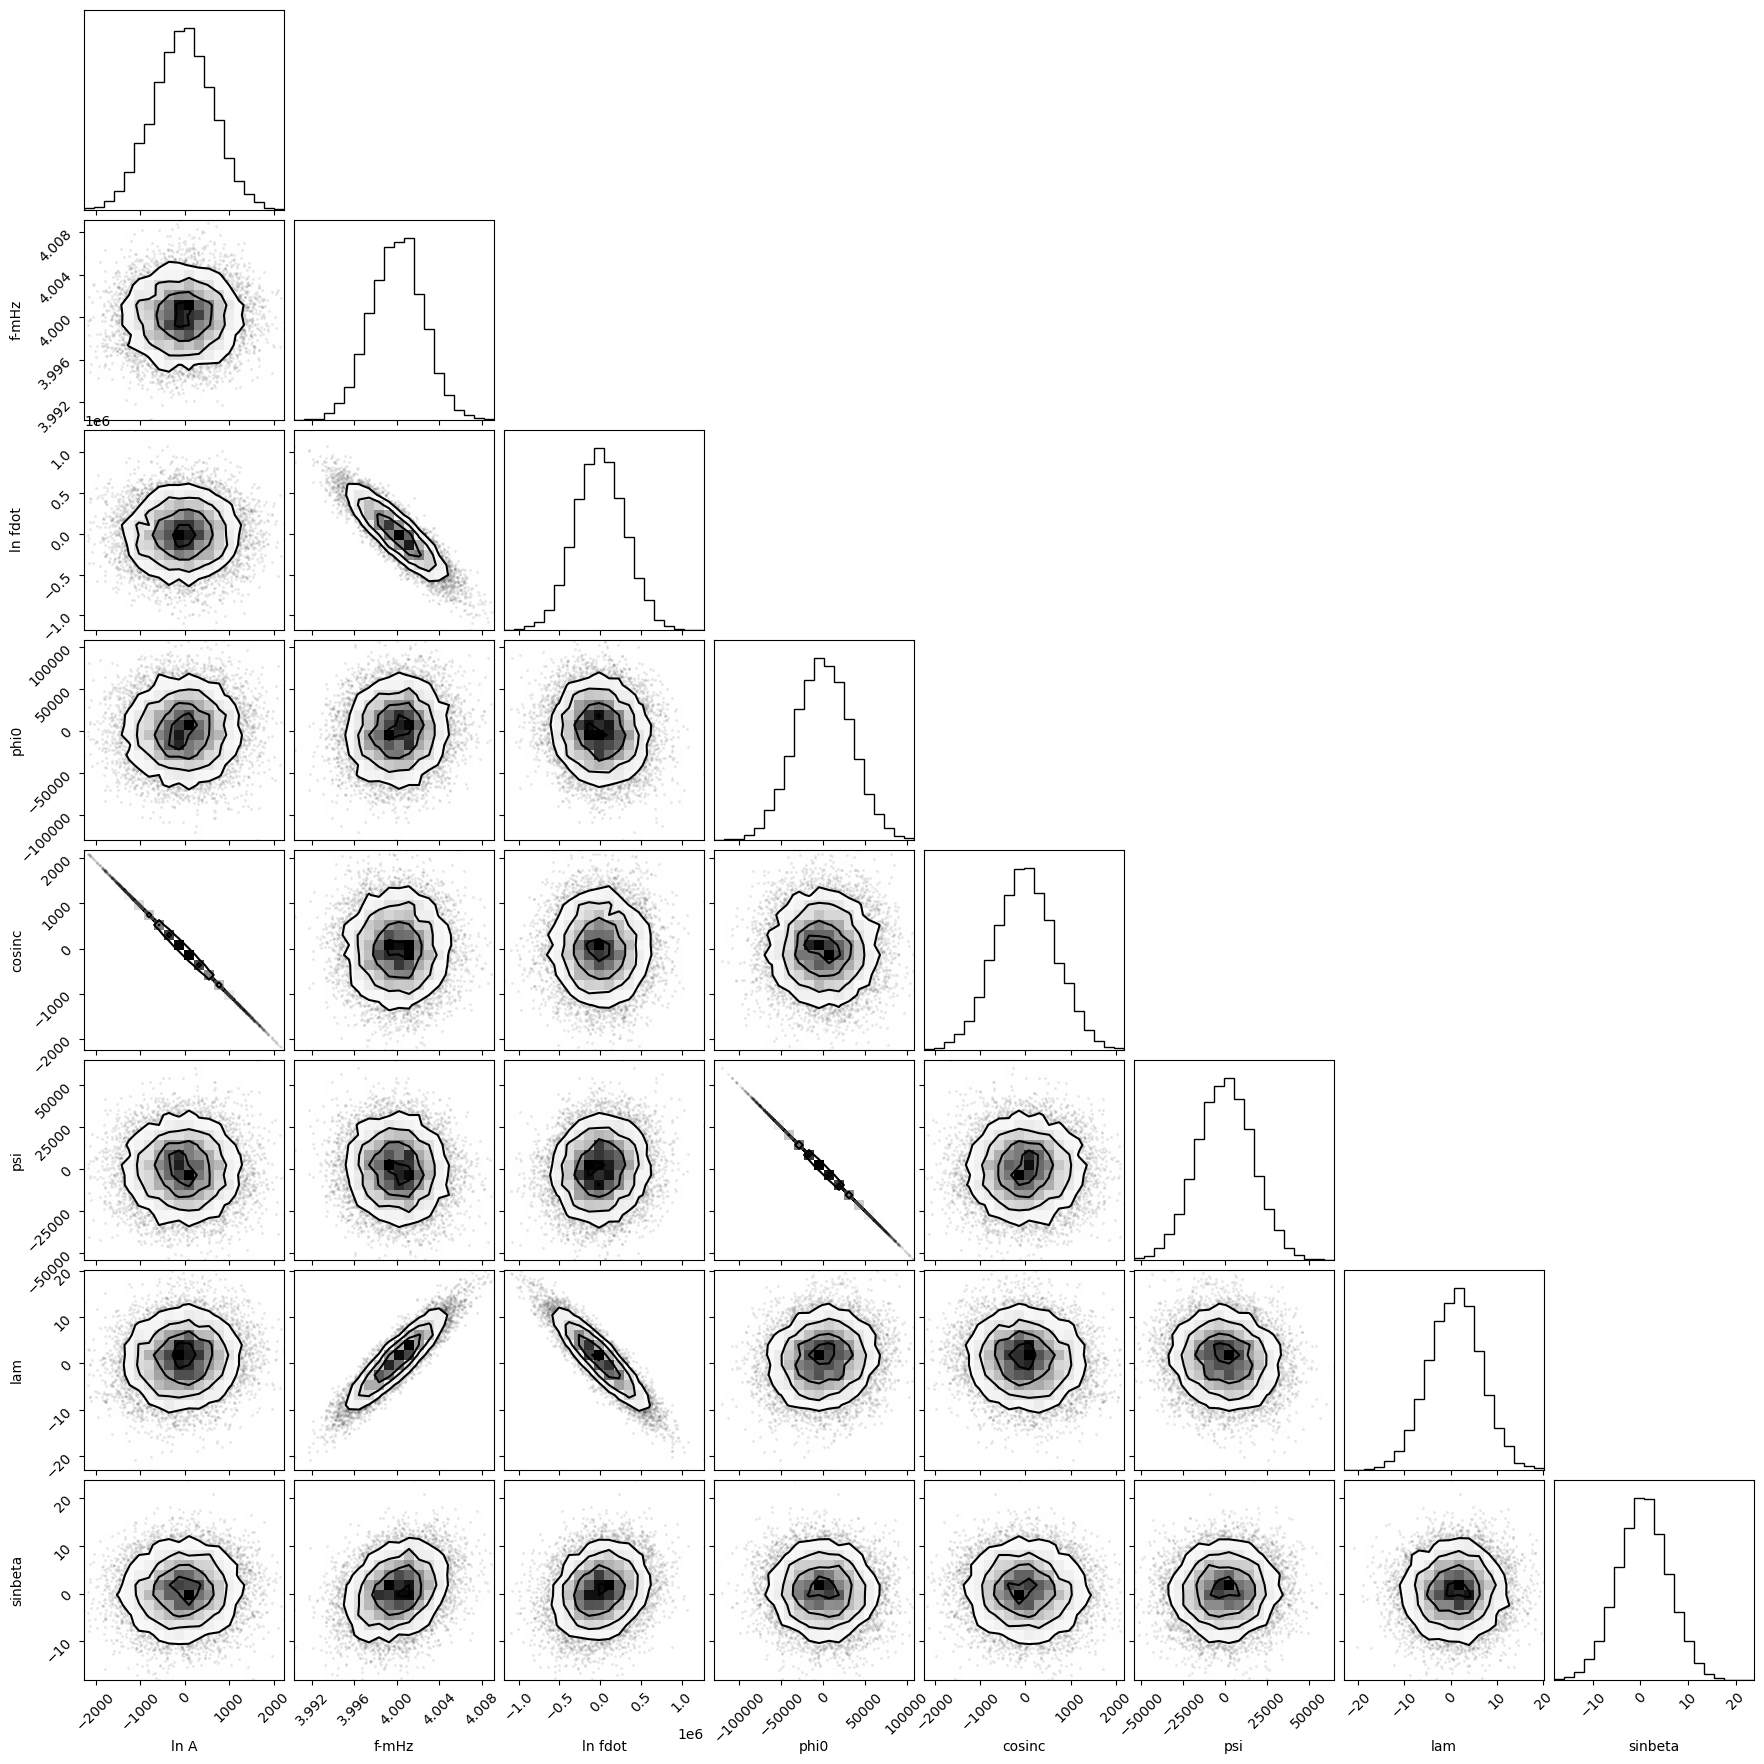

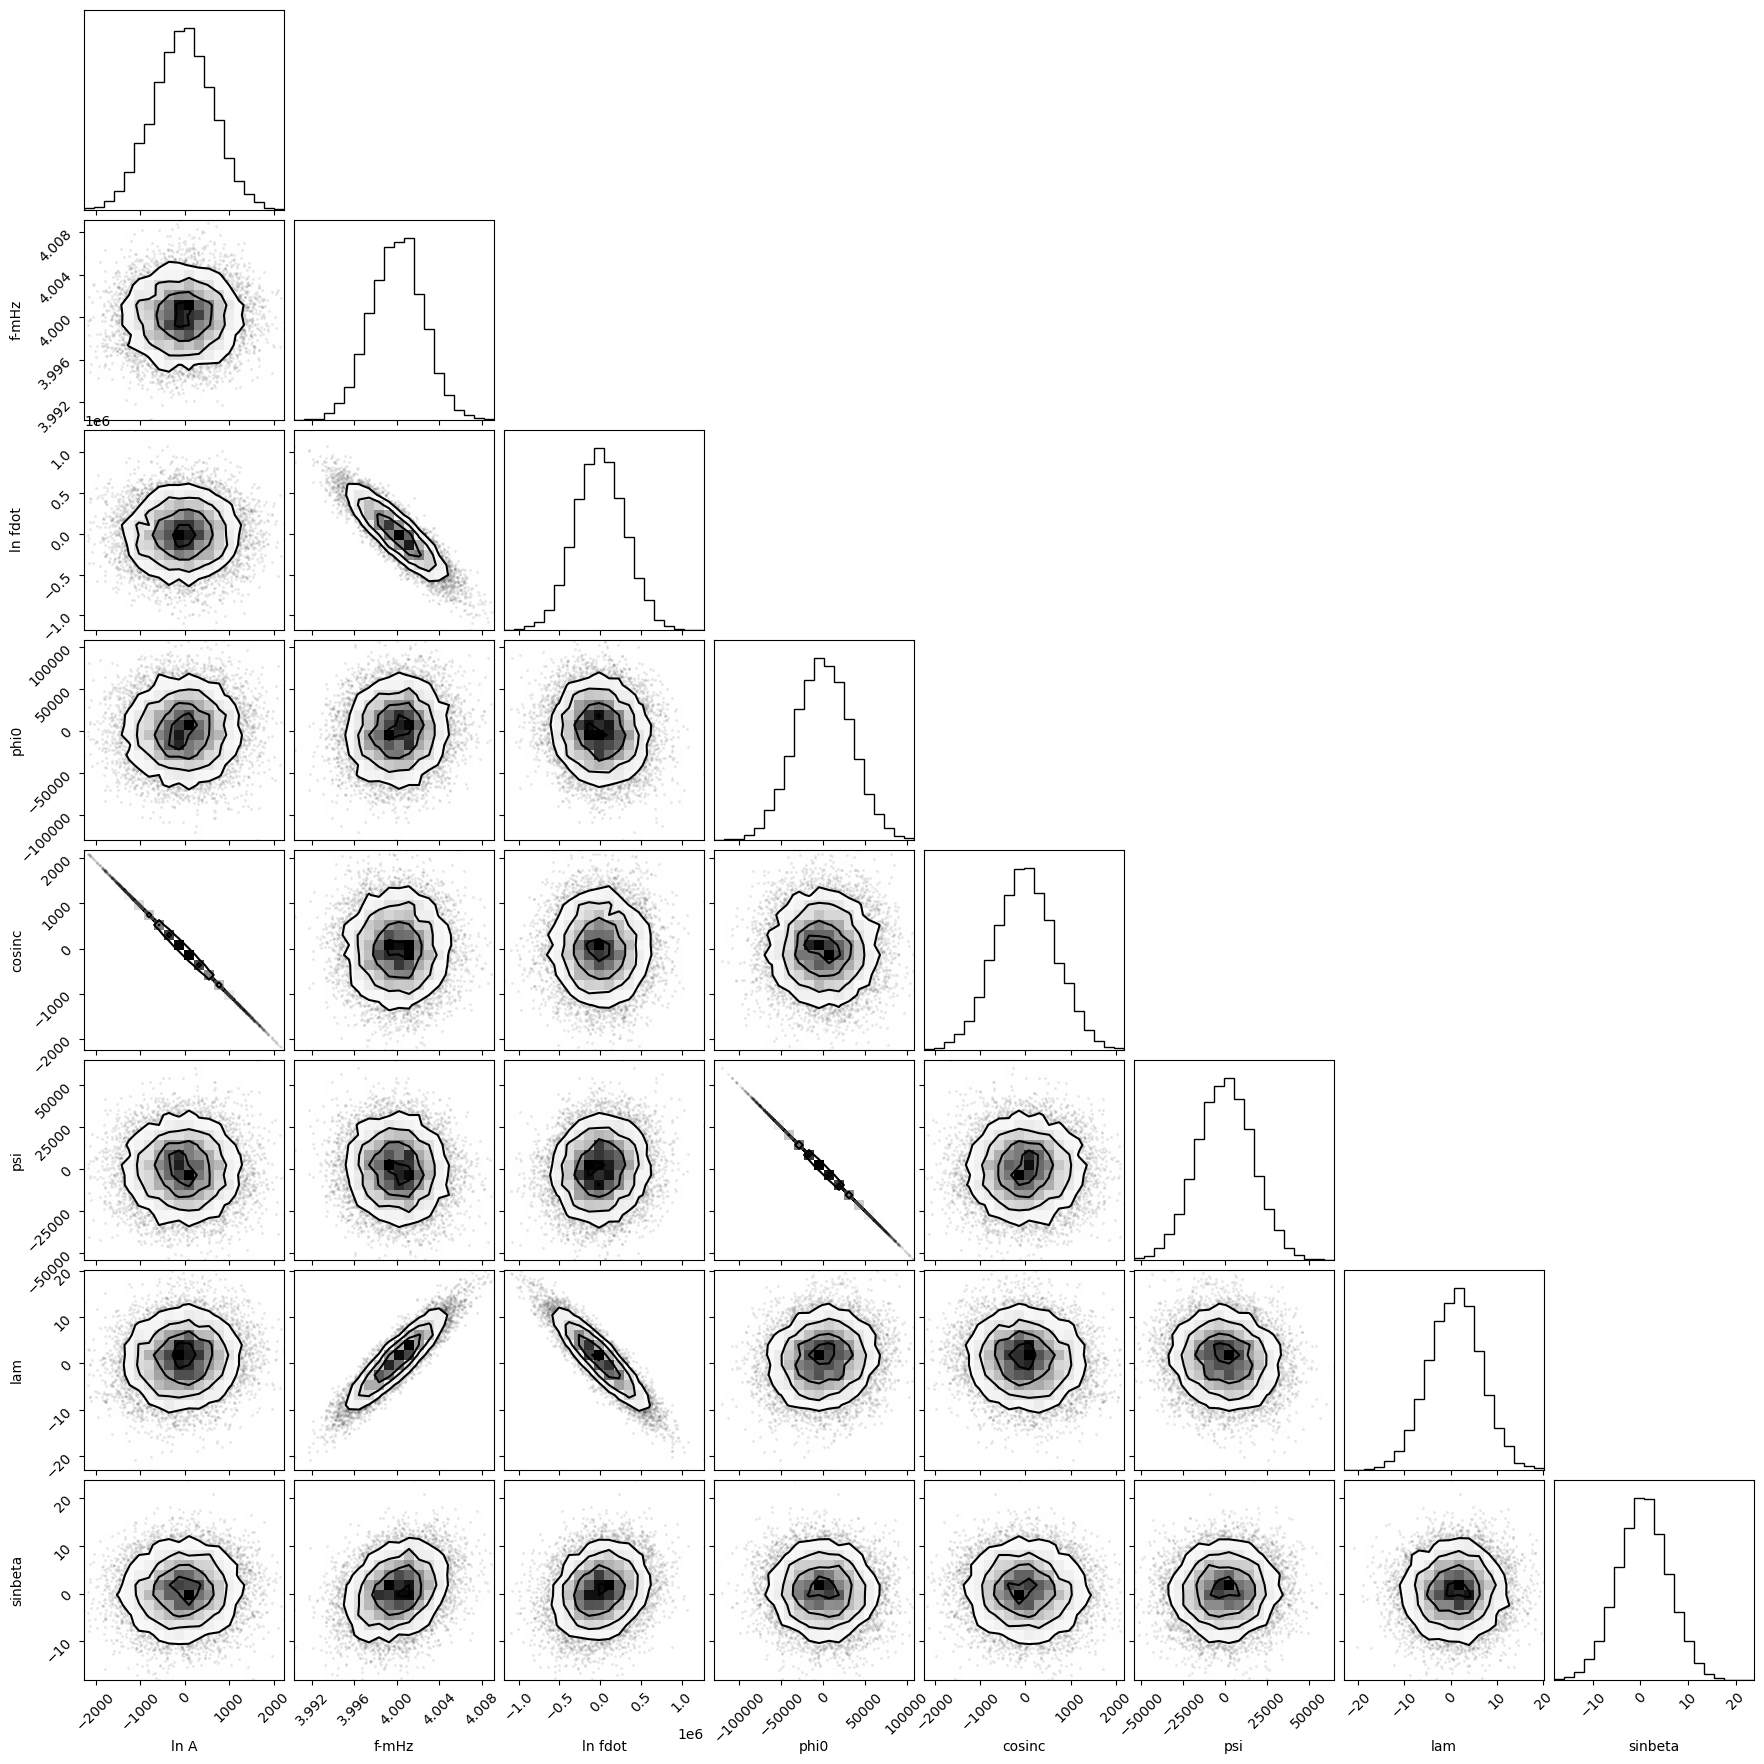

In [19]:
labels=["ln A", "f-mHz", "ln fdot", "phi0", "cosinc", "psi", "lam", "sinbeta"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

#### VGBs Specifically

In [20]:
vgbs = pd.read_csv("vgbs.txt")

/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_46901/2211282476.py:6: RuntimeWarning: invalid value encountered in divide
  ax[i].loglog(fn, (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/lisatools/sensitivity.py:642: ComplexWarning: Casting complex values to real discards the imaginary part
  self._sens_mat = np.asarray(list(new_out), dtype=float).reshape(


lisa_GWB_LISA_HS b'HPLib' 6.611959512413679
lisa_GWB_LISA_HS b'ZTFJ2320' 0.02288876989423203
lisa_GWB_LISA_HS b'SDSSJ0923' 0.2721627123581475
lisa_GWB_LISA_HS b'AMCVn' 11.642069090404643
lisa_GWB_LISA_HS b'CX1751' 0.528899505708662
lisa_GWB_LISA_HS b'ZTFJ2029' 0.4636230190507165
lisa_GWB_LISA_HS b'SDSSJ0935' 5.90009241955188
lisa_GWB_LISA_HS b'ZTFJ1539' 40.33516049455502
lisa_GWB_LISA_HS b'SDSSJ2322' 2.790847563891799
lisa_GWB_LISA_HS b'4U1820-30' 2.3730906499483755
lisa_GWB_LISA_HS b'HMCnc' 105.8670530411135
lisa_GWB_LISA_HS b'CRBoo' 1.9821230533270753
lisa_GWB_LISA_HS b'PTFJ0533' 0.7661283660492917
lisa_GWB_LISA_HS b'HD265435' 0.13488736401518917
lisa_GWB_LISA_HS b'CDm30' 0.2445681620143769
lisa_GWB_LISA_HS b'ZTFJ0640' 0.04588634894660602
lisa_GWB_LISA_HS b'ZTFJ1749' 0.3059177839031458
lisa_GWB_LISA_HS b'SMSSJ0338' 0.5691286796429573
lisa_GWB_LISA_HS b'SDSSJ1630' 0.34281357707292925
lisa_GWB_LISA_HS b'ZTFJ2055' 0.03764142112534525
lisa_GWB_LISA_HS b'ZTFJ1901' 0.15883953476970195
lisa

/Users/mlkatz1/miniconda3/envs/2050_env/lib/python3.12/site-packages/lisatools/diagnostic.py:376: RuntimeWarning: invalid value encountered in sqrt
  opt_snr = np.sqrt(inner_product(sig1, sig1, *args, **kwargs).real)


do_con_GWB_DO_con_HS b'ZTFJ0640' 1.9665261966031746e-06
do_con_GWB_DO_con_HS b'ZTFJ1749' 1.1335774821625131e-05
do_con_GWB_DO_con_HS b'SMSSJ0338' 2.9363285268130834e-05
do_con_GWB_DO_con_HS b'SDSSJ1630' 1.5147809100988612e-05
do_con_GWB_DO_con_HS b'ZTFJ2055' 1.087795139169799e-06
do_con_GWB_DO_con_HS b'ZTFJ1901' 5.7568527662246e-06
do_con_GWB_DO_con_HS b'ZTFJ1946' 2.321380528463155e-06
do_con_GWB_DO_con_HS b'ESCet' 0.0012307318971537925
do_con_GWB_DO_con_HS b'SDSSJ1337' 1.3960849955300828e-05
do_con_GWB_DO_con_HS b'ZTFJ2130' 5.092292948827984e-06
do_con_GWB_DO_con_HS b'V407Vul' 0.0010680367265658952
do_con_GWB_DO_con_HS b'ZTFJ2243' 0.0011415081463548701
do_con_GWB_DO_con_HS b'SDSSJ0634' 0.00010544675291675652
do_con_GWB_DO_con_HS b'ZTFJ0722' 2.2933837207327958e-05
do_con_GWB_DO_con_HS b'PTF1919' 1.3425220875891768e-05
do_con_GWB_DO_con_HS b'V803Cen' 9.777680750145585e-05
do_con_GWB_DO_con_HS b'SDSSJ1351' 0.00011965092890831069
do_con_GWB_DO_con_HS b'SDSSJ1235' 1.5875343893783533e-05
do

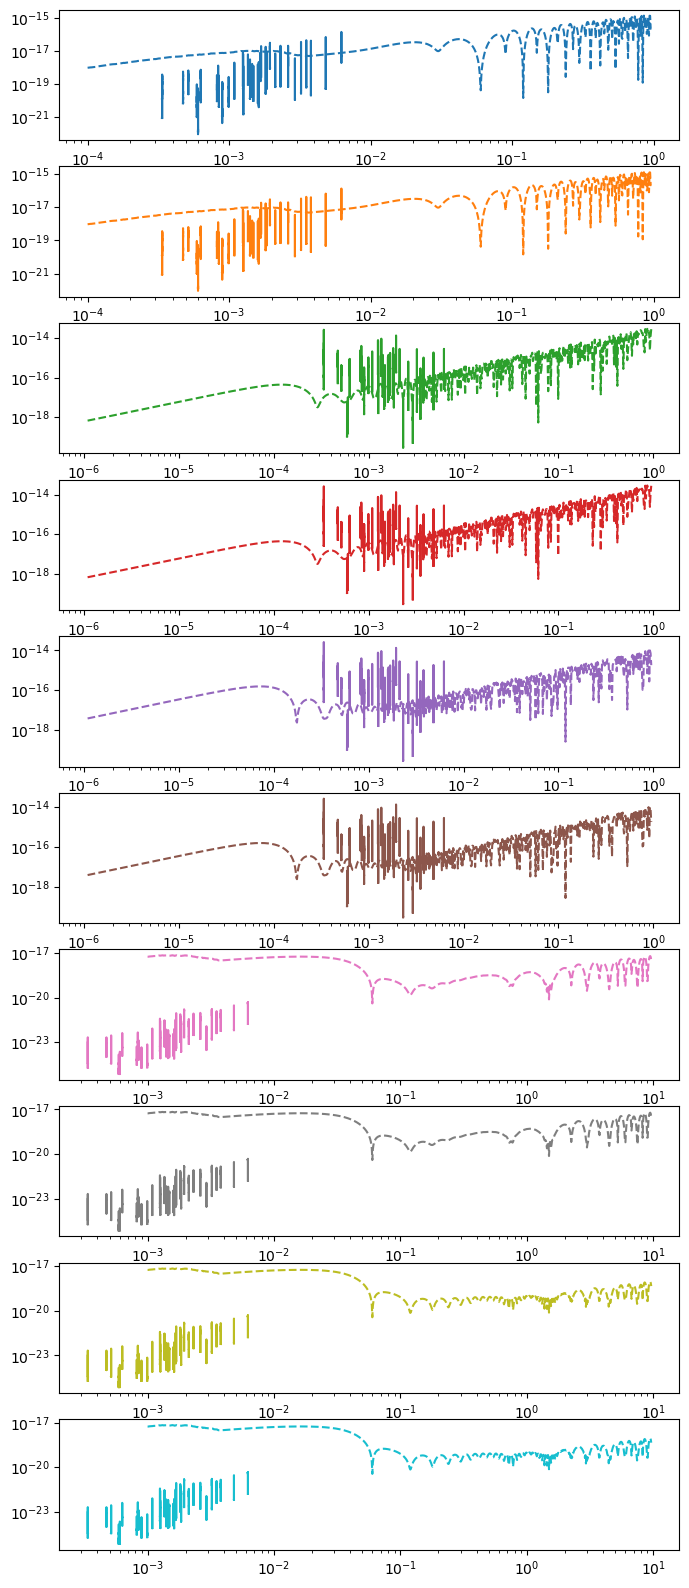

In [21]:
fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 2 * len(list(missions.keys()))))
for i, (name, mission) in enumerate(missions.items()):
    fn = mission["model"].fn
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    df = get_df(mission["Tobs"], mission["dt"])
    ax[i].loglog(fn, (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
    for j in range(len(vgbs)):
        vgb = vgbs.iloc[j]
        params_in = np.array([
            vgb["Amplitude"],
            vgb["Frequency"],
            vgb["FrequencyDerivative"],
            0.0,
            vgb["InitialPhase"],
            vgb["Inclination"],
            vgb["Polarization"],
            vgb["EclipticLongitude"],
            vgb["EclipticLatitude"]
        ])
        print(name, vgb["Name"], mission["gb"].get_snr(*params_in, tdi2=True))
        ax[i].loglog(mission["gb"].f_arr, np.abs(mission["gb"].last_output[0]), c=f"C{i}")

### EMRIs

In [ ]:
M = 1e6
mu = 1e1
a = 0.2
p0 = 12.0
e0 = 0.2
x0 = 0.1
dist = 3.0
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)

fig, ax = plt.subplots(len(list(missions.keys())), 1, figsize=(8, 6))

for i, (name, mission) in enumerate(missions.items()):
    # cannot handle decihertz without adjustments. 
    if name in ["do_con", "do_opt"]: 
        continue
    fn = mission["model"].fn
    print(name, mission["emri"].get_snr(*emri_injection_params))
    Sn = get_sensitivity(fn, model=mission["model"], sens_fn=A1TDISens, **mission["psd_kwargs"])
    emri_freqs = np.fft.rfftfreq(mission["emri"].last_output[0].shape[0], mission["emri"].aet_template_gen.dt)
    ax[i].loglog(emri_freqs, emri_freqs * np.abs(np.fft.rfft(mission["emri"].last_output[0])) * mission["emri"].aet_template_gen.dt, c=f"C{i}")
    ax[i].loglog(fn, np.sqrt(fn) * (Sn / (4 * df)) ** (1/2), c=f"C{i}", ls="--")
